<a href="https://colab.research.google.com/github/haileg12/voiceprint-authentication/blob/main/voiceprint_authentication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Library and Mounting Drive

In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=1bee239cd7890114f59edb3ba476a1fcb7b1ffc70520344da5bf053cf2fac5b9
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For this program, we will extract features from voice data (.wav files) using MFCC. Additionally, we will use it for model training and develop GMMs for model testing.

In order to get a better undertanding of the program, we tested the program two times with varying amounts of data used for machine learning. **The first time we ran the program, the data we used consisted of 10 speakers (5 female and 5 male). Each speaker has 100 wav files (50 for training and 50 for testing).** **The second time we ran the program, the data we used consisted of 10 speakers (5 female and 5 male). Each speaker has 170 wav files (100 for training and 70 for testing).** The dataset we gathered online was already preprocessed.

Finally, we will use our own voice data (.wav files) to test the program's accuracy.

# Importing Libraries and Packages

In [ ]:
# import packages
import numpy as np
import os
import pickle
import warnings
import time
import matplotlib.pyplot as plt
from sklearn import preprocessing
from python_speech_features import mfcc
from scipy.io.wavfile import read
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

# Importing Data

In [ ]:
# import data
warnings.filterwarnings("ignore")

# Path to training data
source = "/content/drive/Shareddrives/cs158project/158Project/data/"
#Path to training student data
sourceStudent = "/content/drive/Shareddrives/cs158project/158Project/StudentData/"

# Path where training speakers will be saved
dest = "/content/drive/Shareddrives/cs158project/158Project/models"
#Path where student training speakers will be saved
destStudent = "/content/drive/Shareddrives/cs158project/158Project/StudentModels"

# Model 1
#train_file = "/content/drive/Shareddrives/cs158project/158Project/training_files1.txt"

# Model 2
train_file = "/content/drive/Shareddrives/cs158project/158Project/training_files2.txt"

file_paths = open(train_file, 'r')

# Visualizing Data

In [ ]:
def plot_spectrogram(audio, rate, filename):
    plt.figure(figsize=(10, 4))
    plt.specgram(audio, Fs=rate, NFFT=512, noverlap=256, cmap='viridis')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(filename)
    plt.colorbar().set_label('Intensity (dB)')
    plt.show()

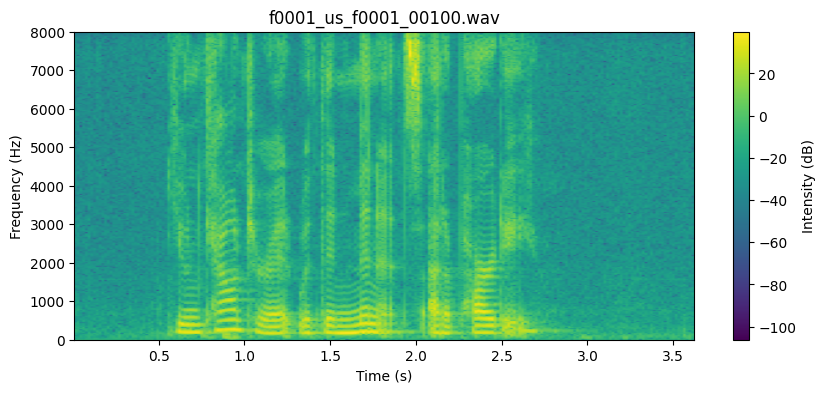

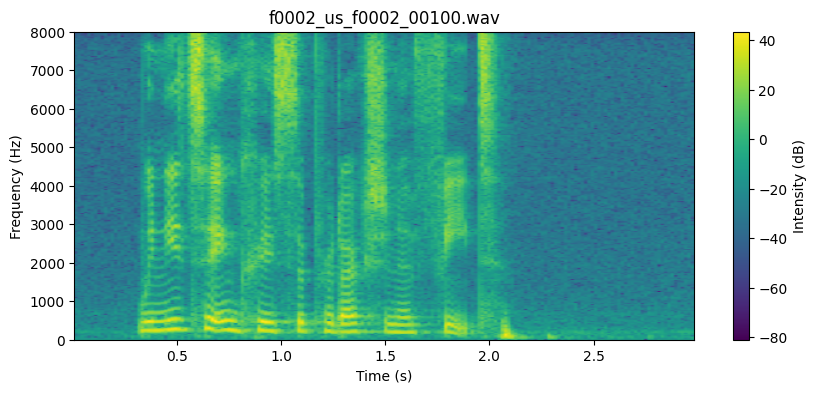

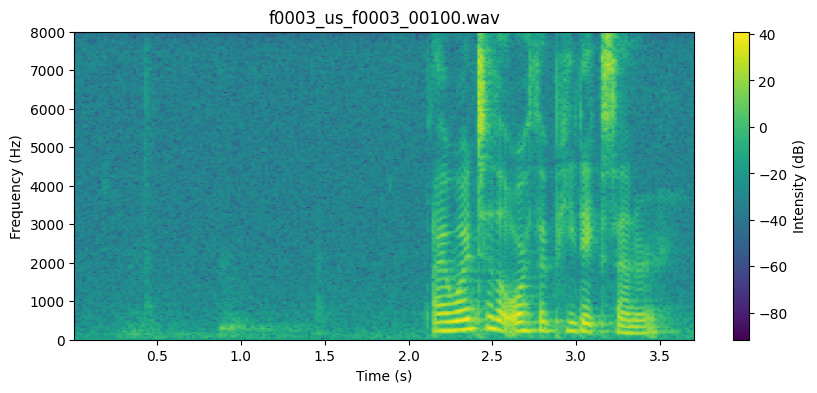

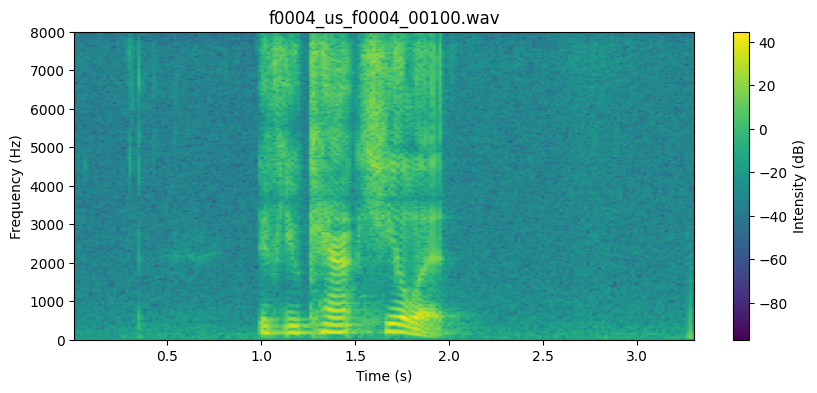

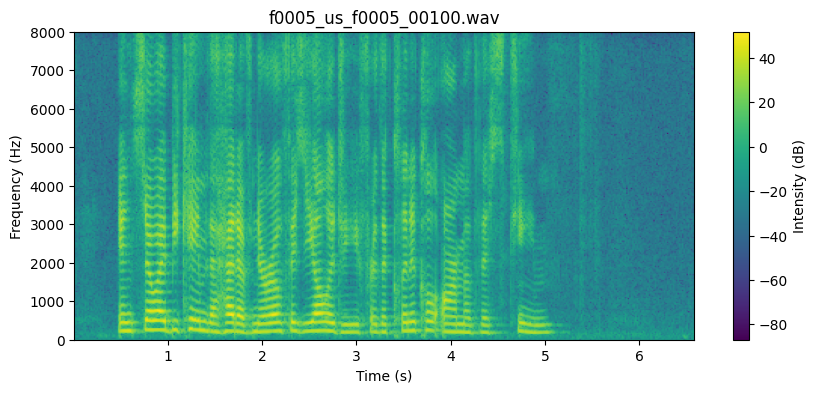

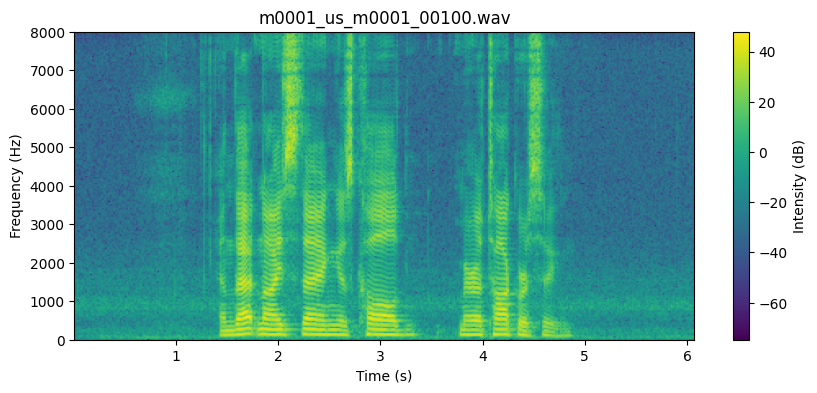

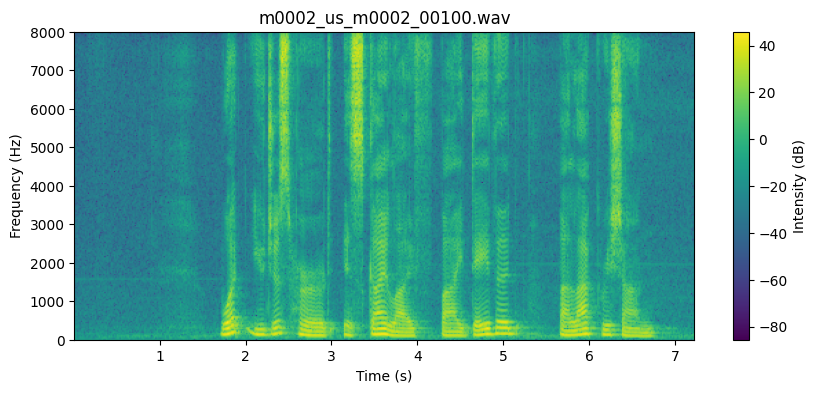

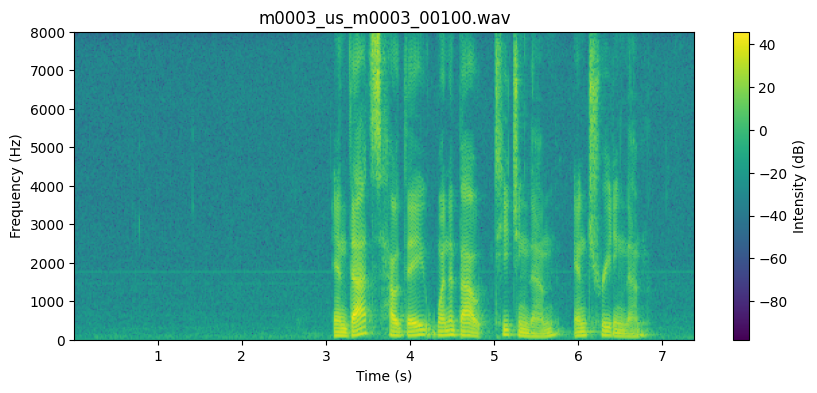

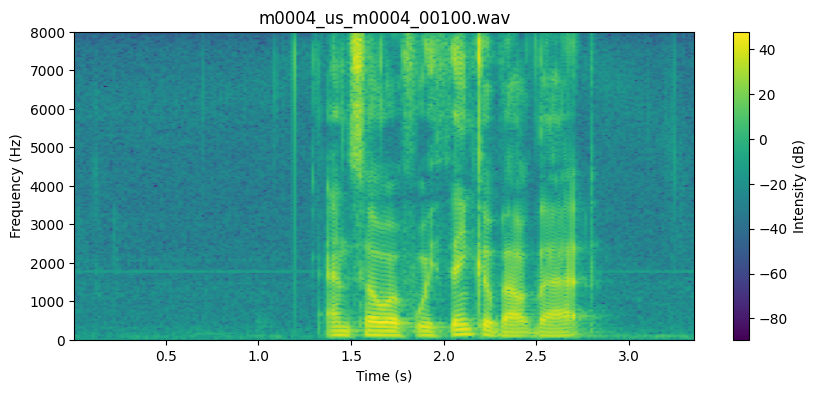

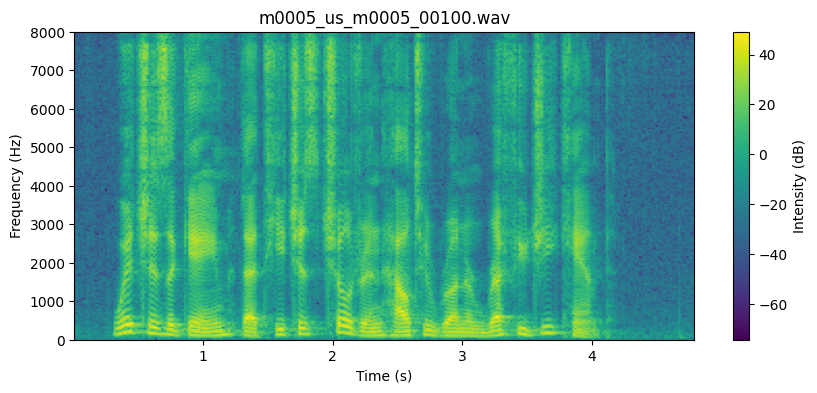

In [ ]:
with open(train_file, 'r') as file_paths:
    counter = 0
    for path in file_paths:
        path = path.strip()

        full_path = os.path.join(source, path)
        # Check if the path is a directory, if so, skip it
        if os.path.isdir(full_path):
            continue

        # Read the audio
        sr, audio = read(full_path)

        # Plot spectrogram with filename as title after every 50 files
        counter += 1
        if counter % 100 == 0:
            plot_spectrogram(audio, sr, os.path.basename(path))

# Preprocessing Data

In [ ]:
def extract_features(audio, rate):
   # Extract 20 dim MFCC features from an audio, performs CMS and combines
   # delta to make it 40 dim feature vector

    mfcc_feat = mfcc(audio, rate, winlen=0.025, winstep=0.01, numcep=20, appendEnergy=True)

    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)
    combined = np.hstack((mfcc_feat, delta))
    return combined

# Feature Extraction and Model Training

In [ ]:
def calculate_delta(array):
    # Calculate and return the delta of given feature vector matrix

    rows, cols = array.shape
    deltas = np.zeros((rows, 20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i - j < 0:
                first = 0
            else:
                first = i - j
            if i + j > rows - 1:
                second = rows - 1
            else:
                second = i + j
            index.append((second, first))
            j += 1
        deltas[i] = (array[index[0][0]] - array[index[0][1]] + (2 * (array[index[1][0]] - array[index[1][1]]))) / 10
    return deltas

In [ ]:
def empty_folder(folder_path):
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)
        # Check if the file is a regular file
        if os.path.isfile(file_path):
            # Delete the file
            os.remove(file_path)

In [ ]:
if __name__ == "__main__":
    print("In main, Call extract_features(audio, signal_rate) as parameters")

In main, Call extract_features(audio, signal_rate) as parameters


In [ ]:
empty_folder(dest)

with open(train_file, 'r') as file_paths:
    count = 1

    # Extracting features for each speaker (5 files per speaker)
    features = np.asarray(())
    for path in file_paths:
        path = path.strip()
        full_path = os.path.join(source, path)  # Full path to the file

        # Check if the path is a directory, if so, skip it
        if os.path.isdir(full_path):
            continue

        print(full_path)

        # Read the audio
        sr, audio = read(full_path)

        # Extract 40 dimensional MFCC & delta MFCC features
        vector = extract_features(audio, sr)

        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features, vector))

        # concatenate features, then do model training
        if count == 100: # change to 50 for model 1  |  change to 100 for model 2

            gmm = GaussianMixture(n_components=16, max_iter=200, covariance_type='diag', n_init=3)
            gmm.fit(features)

            # Dumping the trained Gaussian model
            picklefile = path.split("/")[0] + ".gmm"
            with open(os.path.join(dest, picklefile), 'wb') as f:
                pickle.dump(gmm, f)

            print('+ Modeling completed for speaker:', picklefile, " with data point = ", features.shape)
            features = np.asarray(())
            count = 0
        count = count + 1

/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00001.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00002.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00003.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00004.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00005.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00006.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00007.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00008.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00009.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00010.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00011.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00012.wav
/content/drive/S

# Testing Model

In [ ]:
import time

# Path to test data
source = "/content/drive/Shareddrives/cs158project/158Project/data"
modelpath = "/content/drive/Shareddrives/cs158project/158Project/models/"

# Model 1
#test_file = "/content/drive/Shareddrives/cs158project/158Project/testing_files1.txt"

# Model 2
test_file = "/content/drive/Shareddrives/cs158project/158Project/testing_files2.txt"

file_paths = open(test_file, 'r')

gmm_files = [os.path.join(modelpath, fname) for fname in os.listdir(modelpath) if fname.endswith('.gmm')]

gmm_files

['/content/drive/Shareddrives/cs158project/158Project/models/f0001_us_f0001_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/f0002_us_f0002_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/f0003_us_f0003_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/f0004_us_f0004_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/f0005_us_f0005_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0001_us_m0001_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0002_us_m0002_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0003_us_m0003_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0004_us_m0004_00100.wav.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0005_us_m0005_00100.wav.gmm']

In [ ]:
# Load the Gaussian gender Models
models = [pickle.load(open(fname, 'rb')) for fname in gmm_files]
models

[GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3),
 GaussianMixture(covariance_type='diag', max_iter=200, n_components=16, n_init=3)]

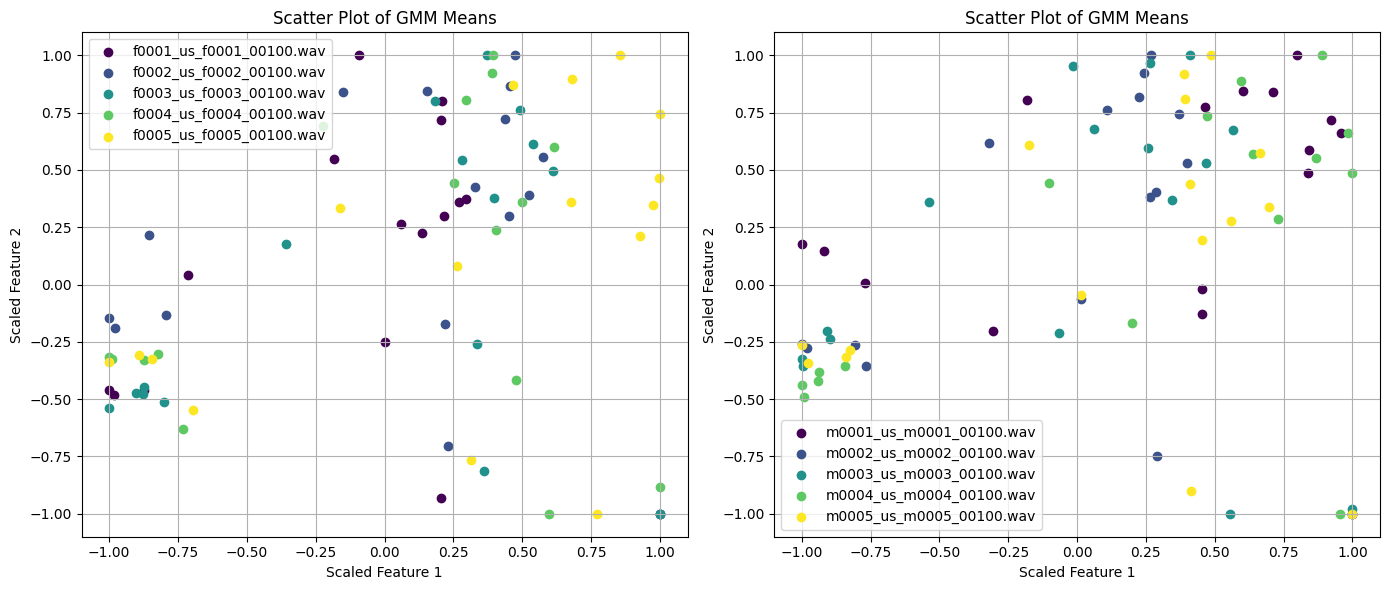

In [ ]:
# Initialize MinMaxScaler with wider feature range
scaler = MinMaxScaler(feature_range=(-1, 1))

# Select different dimensions for the feature vectors
dimensions = [0, 1]  # Change dimensions as needed

# Split the GMM files into two groups
group1_gmm_files = gmm_files[:5]
group2_gmm_files = gmm_files[5:]

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Iterate over each group of GMM files
for ax, gmm_files_group in zip(axes, [group1_gmm_files, group2_gmm_files]):
    # Initialize a list to store means of Gaussian components for the group
    means_list = []

    # Generate colors for each GMM file in the group
    colors = plt.cm.viridis(np.linspace(0, 1, len(gmm_files_group)))

    # Iterate over each GMM file in the group
    for i, gmm_file in enumerate(gmm_files_group):
        # Load the Gaussian mixture model
        gmm_model = pickle.load(open(os.path.join(modelpath, gmm_file), 'rb'))

        # Extract means from the Gaussian mixture model
        means = gmm_model.means_

        # Scale the means
        scaled_means = scaler.fit_transform(means[:, dimensions])

        # Append means to the list
        means_list.append(scaled_means)

        # Plot means of Gaussian components for the current GMM file with a unique color
        color = colors[i]
        ax.scatter(scaled_means[:, 0], scaled_means[:, 1], marker='o', label=gmm_file.split("/")[-1][:-4], color=color)

    # Set title, labels, legend, and grid for the current subplot
    ax.set_title('Scatter Plot of GMM Means')
    ax.set_xlabel('Scaled Feature 1')
    ax.set_ylabel('Scaled Feature 2')
    ax.legend()
    ax.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
actual_speaker = [fname.split("/")[-1].split("_")[0] for fname in gmm_files]
actual_speaker

['f0001',
 'f0002',
 'f0003',
 'f0004',
 'f0005',
 'm0001',
 'm0002',
 'm0003',
 'm0004',
 'm0005']

In [ ]:
# Initialize variables to keep track of correct predictions and total samples
correct_predictions = 0
total_samples = 0
true_positives = 0

# Read the test directory and get the list of test audio files
with open(test_file, 'r') as file_paths:
    for path in file_paths:
        path = path.strip()

        full_path = os.path.join(source, path)
        # Check if the path is a directory, if so, skip it
        if os.path.isdir(full_path):
            continue

        # Read the audio
        sr, audio = read(full_path)

        # Extract features
        vector = extract_features(audio, sr)

        log_likelihood = np.zeros(len(models))

        for i, gmm in enumerate(models):
            scores = np.array(gmm.score(vector))
            log_likelihood[i] = scores.sum()

        if not log_likelihood.any():
            print("No scores computed for the input vector. Check feature extraction or model loading.")
            continue

        # Determine the predicted speaker
        winner = np.argmax(log_likelihood)
        predicted_speaker = actual_speaker[winner]

        # Update counters
        total_samples += 1
        if path.split('_')[0] == predicted_speaker:
            correct_predictions += 1


        # Print information for each test sample
        print("Test file:", path)
        print("Predicted speaker:", predicted_speaker)
        # print("Ground truth speaker:", ground_truth_speaker)
        print("-----------------------------")


Test file: f0001_us_f0001_00101.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00102.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00103.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00104.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00105.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00106.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00107.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00108.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00109.wav
Predicted speaker: f0004
-----------------------------
Test file: f0001_us_f0001_00110.wav
Predicted speaker: f0001
-----------------------------
Test file: f0001_us_f0001_00111.wav
Predicted speaker: f0001
-----------------------------

In [ ]:
# Calculate accuracy
accuracy = (correct_predictions / total_samples) * 100

In [ ]:
# Print Statistics
print("Total samples:", total_samples)
print("Correct predictions:", correct_predictions)
print("Accuracy: {:.2f}%".format(accuracy))

Total samples: 697
Correct predictions: 665
Accuracy: 95.41%


#Results

**Model 1 - 10 Speakers (5 female and 5 male) -> 100 wav files per speaker (50 for training, 50 for testing)**

Total samples: 500

Correct predictions: 477

Accuracy: 95.40%

**Model 2 - 10 Speakers (5 female and 5 male) -> 170 wav files per speaker (100 for training, 70 for testing)**

Total samples: 697

Correct predictions: 665

Accuracy: 95.41%

# Model Training with Student Data

#Model Testing with Student Data